<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/NEW_MIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')
df2 = pd.read_csv('/content/sample_data/input.csv')
df2.drop(df2.tail(9530-8750).index,inplace=True) # drop last n rows
print(df2.shape[0])
print(df.shape[0])
print(df.head())
print(df2.head())

df['sums'] = df2['sums']




df = df[df['n/m']==2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] #cple
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

8750
8750
       inst.name         type  subtype  class  indeks   n   m  n/m  (n/m)^2  \
0  C_1_1_20_10_1  C-instances        1      1       1  20  10  2.0      4.0   
1  C_1_1_20_10_2  C-instances        1      1       2  20  10  2.0      4.0   
2  C_1_1_20_10_3  C-instances        1      1       3  20  10  2.0      4.0   
3  C_1_1_20_10_4  C-instances        1      1       4  20  10  2.0      4.0   
4  C_1_1_20_10_5  C-instances        1      1       5  20  10  2.0      4.0   

   (n/m)^3  ...  (m/n)^3  av.length    std.dev  median  range  min  max   k  \
0      8.0  ...    0.125  51.349998  26.660194    60.5     95    1   96  19   
1      8.0  ...    0.125  52.599998  33.809685    61.0     97    3  100  20   
2      8.0  ...    0.125  43.799999  21.702778    46.5     75    4   79  18   
3      8.0  ...    0.125  46.450001  29.953428    48.0     92    2   94  16   
4      8.0  ...    0.125  43.200001  21.353172    40.5     76    9   85  18   

          y  CPLEXStatus  
0  0.206262  

In [2]:
y_new = []
cnt0=0
cnt1=0
cnt2=0
cnt3=0
for val in y:
  if(val<10):
    y_new.append(0)
    cnt0+=1
  elif(10 <= val and val<1000):
    y_new.append(1)
    cnt1+=1
  else:
    y_new.append(2)
    cnt2+=1

cnt = 0
if(cnt0>0):
  cnt+=1
if(cnt1>0):
  cnt+=1
if(cnt2>0):
  cnt+=1
if(cnt3>0):
  cnt+=1

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)

In [3]:
names = [ 'av.length', 'n', 'std.dev', 'sums', 'max']
X_modified = X.drop([  'm', 'n/m','k', 'indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','median', 'min', 'range'], axis = 1)
print(X_modified.head())
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(random_state=0)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)


     n   av.length     std.dev  max          y       sums
0  180   96.805557   21.808741  151  19.807892  42.222221
1  100  415.119995  111.858437  763   1.563854  46.000000
2  100   52.380001   29.053690   99   8.580274  65.000000
3  140  106.342857   47.798710  239   1.372256  57.142857
4   40   60.825001   24.502106   99   1.949409  60.000000


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [5]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.83)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y'], axis = 1)

X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = X_test.drop(['y'], axis = 1)
X_test = sc.transform(X_test)

1267
260


In [6]:

from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(8, input_dim = X_modified.shape[1]-1, activation='relu'))

classifier.add(Dense(12, activation = 'relu'))
classifier.add(Dropout(0.125))

#classifier.add(Dense(32, activation = 'relu'))

#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(16, activation = 'relu'))

#classifier.add(Dense(16, activation='relu'))

#classifier.add(Dense(8, activation='relu'))

#classifier.add(Dense(12, activation='relu'))

classifier.add(Dense(cnt, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 48        
                                                                 
 dense_1 (Dense)             (None, 12)                108       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 39        
                                                                 
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 64, 
                    epochs = 350, shuffle = True)

Epoch 1/350
20/20 [==============================] - 2s 4ms/step - loss: 1.1080 - accuracy: 0.3433
Epoch 2/350
20/20 [==============================] - 0s 4ms/step - loss: 1.0482 - accuracy: 0.4049
Epoch 3/350
20/20 [==============================] - 0s 2ms/step - loss: 1.0022 - accuracy: 0.4570
Epoch 4/350
20/20 [==============================] - 0s 3ms/step - loss: 0.9607 - accuracy: 0.5328
Epoch 5/350
20/20 [==============================] - 0s 3ms/step - loss: 0.9256 - accuracy: 0.5525
Epoch 6/350
20/20 [==============================] - 0s 6ms/step - loss: 0.8925 - accuracy: 0.5714
Epoch 7/350
20/20 [==============================] - 0s 4ms/step - loss: 0.8686 - accuracy: 0.5888
Epoch 8/350
20/20 [==============================] - 0s 5ms/step - loss: 0.8415 - accuracy: 0.6030
Epoch 9/350
20/20 [==============================] - 0s 3ms/step - loss: 0.8222 - accuracy: 0.6251
Epoch 10/350
20/20 [==============================] - 0s 5ms/step - loss: 0.7944 - accuracy: 0.6401
Epoch 11/

accuracy: 91.15%


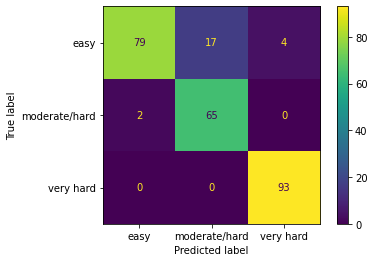

In [8]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])
cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [9]:
column_names = ['n', 'n/m', 'av.length', 'std.dev', 'sums', 'y']
df_reg = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': 2, 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'sums' : X_test_copy.iloc[i]['sums'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)


260
260


In [10]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')
df2 = pd.read_csv('/content/sample_data/input.csv')
df2.drop(df2.tail(9530-8750).index,inplace=True) # drop last n rows
print(df2.shape[0])
print(df.shape[0])
print(df.head())
print(df2.head())

df['sums'] = df2['sums']



df = df[df['n/m']!=2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] 
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

8750
8750
       inst.name         type  subtype  class  indeks   n   m  n/m  (n/m)^2  \
0  C_1_1_20_10_1  C-instances        1      1       1  20  10  2.0      4.0   
1  C_1_1_20_10_2  C-instances        1      1       2  20  10  2.0      4.0   
2  C_1_1_20_10_3  C-instances        1      1       3  20  10  2.0      4.0   
3  C_1_1_20_10_4  C-instances        1      1       4  20  10  2.0      4.0   
4  C_1_1_20_10_5  C-instances        1      1       5  20  10  2.0      4.0   

   (n/m)^3  ...  (m/n)^3  av.length    std.dev  median  range  min  max   k  \
0      8.0  ...    0.125  51.349998  26.660194    60.5     95    1   96  19   
1      8.0  ...    0.125  52.599998  33.809685    61.0     97    3  100  20   
2      8.0  ...    0.125  43.799999  21.702778    46.5     75    4   79  18   
3      8.0  ...    0.125  46.450001  29.953428    48.0     92    2   94  16   
4      8.0  ...    0.125  43.200001  21.353172    40.5     76    9   85  18   

          y  CPLEXStatus  
0  0.206262  

In [11]:
y_new = []
for val in y:
  if(val<10):
    y_new.append(0)
  elif(10 <= val and val <1000):
    y_new.append(1)
  else:
    y_new.append(2)

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)
X_modified = X

In [12]:
from imblearn.over_sampling import RandomOverSampler

names =[ 'std.dev', 'n','n/m', 'max','av.length', 'sums']
X_modified = X.drop([  'median', 'range',  'min','indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','m'], axis = 1)
X_modified['n/m'] = X_modified['n/m']
#print(X_modified.head())

oversample = RandomOverSampler(random_state=0)
#oversample.fit(X_modified, y_encoded)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)

In [13]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [14]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.83)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y', 'sums'], axis = 1)
X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = X_test.drop(['y', 'sums'], axis = 1)
X_test = sc.transform(X_test)

11401
2336


In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(16, input_dim = X_modified.shape[1]-2, activation='relu'))

classifier.add(Dropout(0.2))

classifier.add(Dense(3, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                112       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


In [16]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 32, 
                    epochs = 120)

Epoch 1/120
357/357 [==============================] - 1s 2ms/step - loss: 0.5994 - accuracy: 0.7790
Epoch 2/120
357/357 [==============================] - 1s 1ms/step - loss: 0.4214 - accuracy: 0.8388
Epoch 3/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3831 - accuracy: 0.8505
Epoch 4/120
357/357 [==============================] - 1s 1ms/step - loss: 0.3633 - accuracy: 0.8590
Epoch 5/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3473 - accuracy: 0.8639
Epoch 6/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3424 - accuracy: 0.8678
Epoch 7/120
357/357 [==============================] - 1s 1ms/step - loss: 0.3352 - accuracy: 0.8707
Epoch 8/120
357/357 [==============================] - 1s 1ms/step - loss: 0.3277 - accuracy: 0.8755
Epoch 9/120
357/357 [==============================] - 1s 1ms/step - loss: 0.3202 - accuracy: 0.8770
Epoch 10/120
357/357 [==============================] - 1s 1ms/step - loss: 0.3179 - accura

accuracy: 91.05%


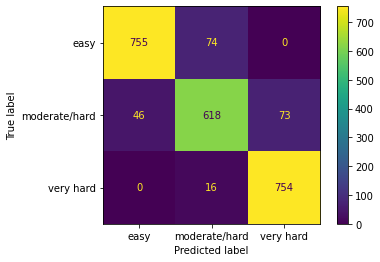

In [17]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])

cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [18]:
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': X_test_copy.iloc[i]['n/m'], 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'sums' : X_test_copy.iloc[i]['sums'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)

In [19]:
print(df_reg.shape[0])
print(df_reg.head(500))

790
         n    n/m   av.length     std.dev       sums           y
0    160.0   2.00   98.750000   20.846851  41.250000   12.711509
1    180.0   2.00   97.027779   45.132622  59.444443    3.551460
2    200.0   2.00   73.769997   14.858026  40.500000   19.744289
3    180.0   2.00   61.305557   22.736803  53.888889   23.756390
4    200.0   2.00   53.240002   28.687759  64.500000   36.112316
..     ...    ...         ...         ...        ...         ...
495   40.0  10.00  158.024994   43.862537  20.000000   97.773735
496  162.0   3.00   51.938271   28.586298  55.555557   60.121170
497  108.0   2.25  429.944458  114.032120  41.666668   40.939331
498  180.0   4.00   75.622223   14.227270  22.222221   74.072678
499   36.0   9.00  107.138885   50.197411  33.333332  125.199760

[500 rows x 6 columns]


In [20]:
for i in range(df_reg.shape[0]):
  if(df_reg.iloc[i]['y'] == 99999):
    df_reg.loc[i, 'y'] = 4510

print(df_reg['y'].max())
shuffled = df_reg.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

4510.0


In [21]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

5742
5742


In [22]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [23]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


75/75 [==============================] - 1s 2ms/step - loss: 2300802.0000
Epoch 2/300
75/75 [==============================] - 0s 2ms/step - loss: 514218.6250
Epoch 3/300
75/75 [==============================] - 0s 2ms/step - loss: 260633.9531
Epoch 4/300
75/75 [==============================] - 0s 2ms/step - loss: 199750.5469
Epoch 5/300
75/75 [==============================] - 0s 2ms/step - loss: 167075.5469
Epoch 6/300
75/75 [==============================] - 0s 2ms/step - loss: 148261.6562
Epoch 7/300
75/75 [==============================] - 0s 2ms/step - loss: 133667.7344
Epoch 8/300
75/75 [==============================] - 0s 2ms/step - loss: 125642.1016
Epoch 9/300
75/75 [==============================] - 0s 2ms/step - loss: 120542.1016
Epoch 10/300
75/75 [==============================] - 0s 2ms/step - loss: 114001.2891
Epoch 11/300
75/75 [==============================] - 0s 2ms/step - loss: 110278.4844
Epoch 12/300
75/75 [==============================] - 0s 3ms/step - loss: 

In [24]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

16/16 [==============================] - 0s 2ms/step
r_square score:  0.9769324030815872
RMSE:


60.70735941218136

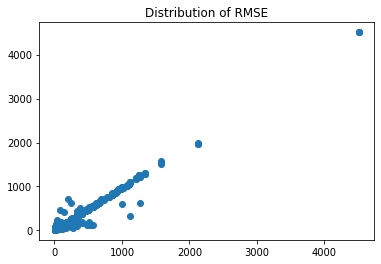

In [25]:
plt.title('Distribution of RMSE')

plt.scatter(yy, predd)

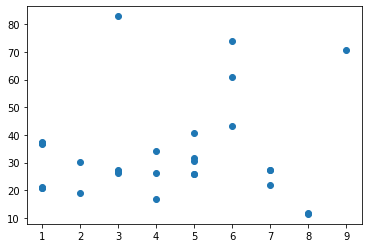

In [26]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]<10):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)
#plt.ylim([0, 100])

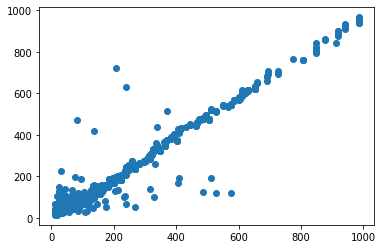

In [27]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>=10 and yy[i]<1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)

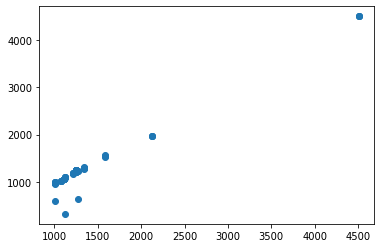

In [28]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>=1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)